In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from __init__ import *
import numpy as np
from svg_reader import SVGReader
from helpers.helpers import filter_none
from placement.attract import *
from visuals.plotter import plot_general
from copy import deepcopy
import networkx as nx
from itertools import pairwise, accumulate, product
from functools import reduce
from operator import add
from helpers.helpers import sort_and_group_objects
from domains.domain import Domain
from placement.neighbors import *
from placement.cardinal import *
from identify.id_problems import report_problems
from actions.selection import *
from helpers.layout import Layout
import plotly.io as pio
from icecream import ic


In [6]:

from pathlib import Path
svgs = Path.cwd().parent.parent / "svg_imports"

In [56]:
case  = svgs / f"red_b1.svg"
sv = SVGReader(case)
sv.run()
domains = sv.domains
pos = create_pos(domains)


Removed outlier domains: {'image 1'}


In [26]:
not domains[""].name

True

In [57]:
plot_general(domains)

In [39]:
import seaborn as sns
from scipy import stats

In [52]:
areas = [i.area for i in domains.values()]
z = np.abs(stats.zscore(areas))
areas

[Decimal('153.2012'),
 Decimal('10.8683'),
 Decimal('7.3932'),
 Decimal('6.6368'),
 Decimal('6.7728'),
 Decimal('3.2802'),
 Decimal('0.7546'),
 Decimal('3.1125'),
 Decimal('1.8410'),
 Decimal('1.6800'),
 Decimal('4.8116'),
 Decimal('11.4754')]

In [47]:
areas

[Decimal('153.2012'),
 Decimal('10.8683'),
 Decimal('7.3932'),
 Decimal('6.6368'),
 Decimal('6.7728'),
 Decimal('3.2802'),
 Decimal('0.7546'),
 Decimal('3.1125'),
 Decimal('1.8410'),
 Decimal('1.6800'),
 Decimal('4.8116'),
 Decimal('11.4754')]

In [54]:
def filter_outlier_rectangles(domains: DomainsDict):
    threshold_z = 2
    domains_list = list(domains.values())
    areas = [i.area for i in domains_list]
    z = np.abs(stats.zscore(areas))
    outlier_indices = np.where(z > threshold_z)[0]
    valid_domains = [domains_list[ix] for ix, _ in enumerate(domains_list) if ix not in outlier_indices]
    return {i.name:i for i in valid_domains}
    


In [55]:
filter_outlier_rectangles(domains)

{'dining': Domain(dining, x=[0.00-4.33], y=[3.57-6.08]),
 'bedroom_1': Domain(bedroom_1, x=[4.43-7.46], y=[3.64-6.08]),
 'bedroom_2': Domain(bedroom_2, x=[7.56-10.28], y=[3.64-6.08]),
 'prim_bed': Domain(prim_bed, x=[7.56-10.28], y=[0.00-2.49]),
 'prim_bath': Domain(prim_bath, x=[4.73-6.86], y=[0.00-1.54]),
 'prim_bed2': Domain(prim_bed2, x=[7.07-7.56], y=[0.00-1.54]),
 'bath_1': Domain(bath_1, x=[3.37-4.62], y=[0.00-2.49]),
 'laundry': Domain(laundry, x=[4.83-7.46], y=[1.79-2.49]),
 'closet': Domain(closet, x=[8.60-10.28], y=[2.57-3.57]),
 'transit': Domain(transit, x=[3.24-8.47], y=[2.57-3.49]),
 'living': Domain(living, x=[0.07-3.24], y=[-0.10-3.52])}

In [48]:
threshold_z = 2

outlier_indices = np.where(z > threshold_z)[0]
[areas[ix] for ix, _ in enumerate(areas) if ix not in outlier_indices]

[Decimal('10.8683'),
 Decimal('7.3932'),
 Decimal('6.6368'),
 Decimal('6.7728'),
 Decimal('3.2802'),
 Decimal('0.7546'),
 Decimal('3.1125'),
 Decimal('1.8410'),
 Decimal('1.6800'),
 Decimal('4.8116'),
 Decimal('11.4754')]

<Axes: >

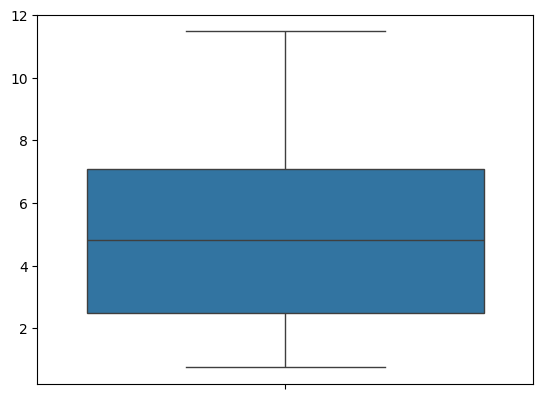

In [50]:

sns.boxplot(areas[1:])

[Decimal('153.2012'),
 Decimal('10.8683'),
 Decimal('7.3932'),
 Decimal('6.6368'),
 Decimal('6.7728'),
 Decimal('3.2802'),
 Decimal('0.7546'),
 Decimal('3.1125'),
 Decimal('1.8410'),
 Decimal('1.6800'),
 Decimal('4.8116'),
 Decimal('11.4754')]

In [13]:
from xml.dom import minidom

In [19]:
doc = minidom.parse(str(sv.svg_path))
rectangles = [
            path
            for path in doc.getElementsByTagName("rect") if path.hasAttribute("id")
        ]

In [20]:
rectangles

[<DOM Element: rect at 0x12733e200>,
 <DOM Element: rect at 0x12733dab0>,
 <DOM Element: rect at 0x12733df30>,
 <DOM Element: rect at 0x12733c160>,
 <DOM Element: rect at 0x12733d240>,
 <DOM Element: rect at 0x1274b24d0>,
 <DOM Element: rect at 0x1274b2050>,
 <DOM Element: rect at 0x1274b2290>,
 <DOM Element: rect at 0x1274b2680>,
 <DOM Element: rect at 0x1274b2710>,
 <DOM Element: rect at 0x1274b1990>]

In [12]:
sv.rectangles

[SVGRect(x=0.0, y=0.0, width=261.0, height=151.0, id='dining'),
 SVGRect(x=267.0, y=0.0, width=182.0, height=147.0, id='bedroom_1'),
 SVGRect(x=455.0, y=0.0, width=164.0, height=147.0, id='bedroom_2'),
 SVGRect(x=455.0, y=216.0, width=164.0, height=150.0, id='prim_bed'),
 SVGRect(x=285.0, y=273.0, width=128.0, height=93.0, id='prim_bath'),
 SVGRect(x=426.0, y=273.0, width=29.0, height=93.0, id='prim_bed2'),
 SVGRect(x=203.0, y=216.0, width=75.0, height=150.0, id='bath_1'),
 SVGRect(x=291.0, y=216.0, width=158.0, height=42.0, id='laundry'),
 SVGRect(x=518.0, y=151.0, width=101.0, height=60.0, id='closet'),
 SVGRect(x=195.0, y=156.0, width=315.0, height=55.0, id='transit'),
 SVGRect(x=4.0, y=154.0, width=191.0, height=218.0, id='living')]

In [40]:
domains

{'dining': Domain(dining, x=[0.00-4.33], y=[3.57-6.08]),
 'bedroom_1': Domain(bedroom_1, x=[4.43-7.46], y=[3.64-6.08]),
 'bedroom_2': Domain(bedroom_2, x=[7.56-10.28], y=[3.64-6.08]),
 'prim_bed': Domain(prim_bed, x=[7.56-10.28], y=[0.00-2.49]),
 'prim_bath': Domain(prim_bath, x=[4.73-6.86], y=[0.00-1.54]),
 'prim_bed2': Domain(prim_bed2, x=[7.07-7.56], y=[0.00-1.54]),
 'bath_1': Domain(bath_1, x=[3.37-4.62], y=[0.00-2.49]),
 'laundry': Domain(laundry, x=[4.83-7.46], y=[1.79-2.49]),
 'closet': Domain(closet, x=[8.60-10.28], y=[2.57-3.57]),
 'transit': Domain(transit, x=[3.24-8.47], y=[2.57-3.49]),
 'living': Domain(living, x=[0.07-3.24], y=[-0.10-3.52])}

In [41]:
plot_general(sv.layout.domains)


In [42]:
ad_layout = adjust_domains(domains)
a_domains, [Gx, Gy] = ad_layout
Gxc, Gyc = create_cardinal_dags(ad_layout)


In [43]:
plot_general(ad_layout.domains)

In [44]:
fl = FixLayout(ad_layout)
fl.run_to_completion()

initializing.. 0
next best layout prim_bed2-STRETCH-for-HOLE near ['prim_bed2', 'prim_bed']3-PS:0.90-S:1.95
running again 1
next best layout laundry-STRETCH-for-HOLE near ['laundry', 'transit']2-PS:0.88-S:1.44
running again 2
next best layout bedroom_2-PULL-for-HOLE near ['transit', 'bedroom_2']2-PS:0.54-S:1.27
running again 3
next best layout closet-SQUEEZE-for-OVERLAP near ['closet', 'bedroom_2']1-PS:0.38-S:0.69
running again 4
next best layout dining-PULL-for-HOLE near ['transit', 'dining']1-PS:0.44-S:0.72
running again 5
next best layout living-PUSH-for-OVERLAP near ['living', 'dining']0-PS:0.22-S:0.11
No more results!
Found best layout: living-PUSH-for-OVERLAP near ['living', 'dining']0-PS:0.22-S:0.11


In [45]:
from actions.leveler import level_sides


new_doms = level_sides(fl.bl.layout)

In [46]:
plot_general(new_doms)